In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from scipy.signal import correlate
import glob

In [67]:
subject = "s10"
# Load the data
sit: pd.DataFrame = pd.read_csv("data/" + subject + "_sit.csv")
sit["time"] = pd.to_datetime(sit["time"])

walk: pd.DataFrame = pd.read_csv("data/" + subject + "_walk.csv")
walk["time"] = pd.to_datetime(walk["time"])

run: pd.DataFrame = pd.read_csv("data/" + subject + "_run.csv")
run["time"] = pd.to_datetime(run["time"])
sit.head()

,time,ecg,peaks,pleth_1,pleth_2,pleth_3,pleth_4,pleth_5,pleth_6,lc_1,lc_2,temp_1,temp_2,temp_3,a_x,a_y,a_z,g_x,g_y,g_z
0,2021-01-01 11:42:11.380563,29634,0,66165,68100,3605,90569,99964,6084,6309080,6604837,33.94,36.00,33.172401,5.588950,4.046407,-6.884279,0.000282,-0.071532,0.036767
1,2021-01-01 11:42:11.382563,29687,0,66160,68084,3603,90569,99964,6084,6309080,6604837,33.94,36.00,33.178394,5.601521,4.040421,-6.910018,0.002013,-0.071799,0.033970
2,2021-01-01 11:42:11.384563,29785,0,66149,68081,3606,90571,99960,6082,6308823,6603053,33.94,36.00,33.175400,5.614689,4.033238,-6.938151,0.003079,-0.073396,0.031440
3,2021-01-01 11:42:11.386563,29887,0,66153,68071,3594,90580,99967,6084,6308823,6603053,33.94,36.00,33.181389,5.620076,4.036231,-6.944736,0.004144,-0.075793,0.028644
4,2021-01-01 11:42:11.388563,29944,0,66153,68071,3594,90579,99948,6082,6308823,6603053,33.94,35.63,33.184383,5.618280,4.024858,-6.936954,0.004810,-0.079122,0.025182


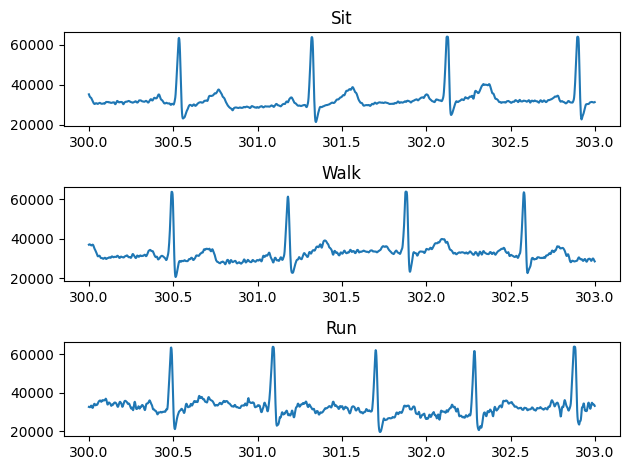

In [18]:
from matplotlib.dates import DateFormatter

frequency = 500  # Hz

figs, axes = plt.subplots(3, 1)

axes[0].plot(
    sit.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    sit["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[0].set_title("Sit")


axes[1].plot(
    walk.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    walk["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[1].set_title("Walk")


axes[2].plot(
    run.index[5 * 60 * frequency : (5 * 60 + 3) * frequency] / frequency,
    run["ecg"][5 * 60 * frequency : (5 * 60 + 3) * frequency],
    label="ecg",
)
axes[2].set_title("Run")


plt.tight_layout()

/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(0.0, 200.0)

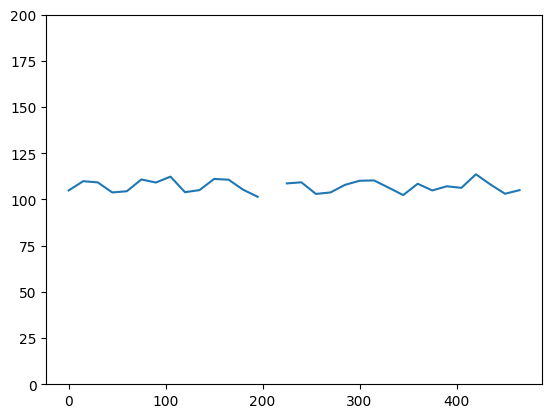

In [81]:
def windowed_auto_correlation_periods(signal, window_size):
    periods = []
    for i in range(
        0,
        len(signal) // window_size,
    ):
        window = signal[i * window_size : (i + 1) * window_size]
        window = window - np.mean(window)
        auto_correlation = np.correlate(window, window, mode="full")
        auto_correlation = auto_correlation / np.max(auto_correlation)
        local_max = np.where(auto_correlation > 0.2)[0]

        diff = np.diff(local_max)
        diff = diff[diff > 200]
        diff = diff[diff < 350]
        periods.append(60 * frequency / np.mean(diff))
    return periods


window = 15  # seconds
run_windowed_auto_correlation = windowed_auto_correlation_periods(
    run["ecg"], window * frequency
)
plt.plot(
    window * np.arange(0, len(run_windowed_auto_correlation)),
    run_windowed_auto_correlation,
)
plt.ylim(0, 200)

In [94]:
cross_correlations = {}
columns = ["ecg", "pleth_3", "pleth_6", "lc_1", "lc_2"]
for column_i in columns:
    for column_j in columns:
        if column_i == column_j:
            continue
        if column_j + "_" + column_i in cross_correlations:
            continue
        cross_correlations[column_i + "_" + column_j] = correlate(
            run[column_i] - run[column_i].mean(),
            run[column_j] - run[column_j].mean(),
            mode="full",
        )
        cross_correlations[column_i + "_" + column_j] = cross_correlations[
            column_i + "_" + column_j
        ] / np.max(cross_correlations[column_i + "_" + column_j])

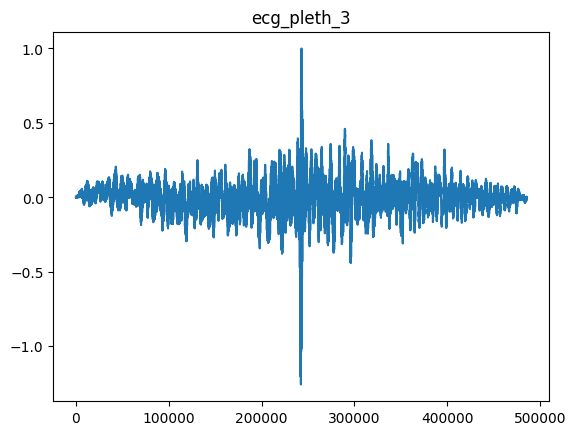

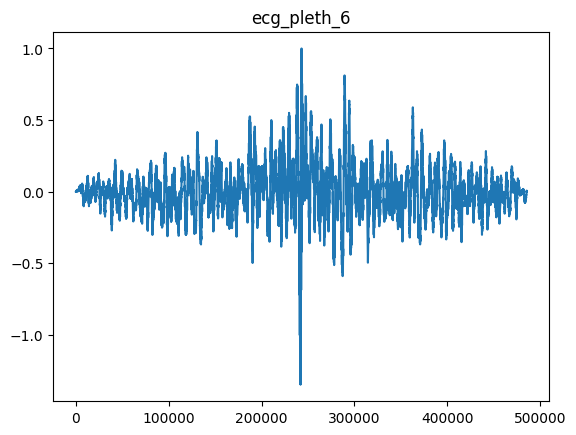

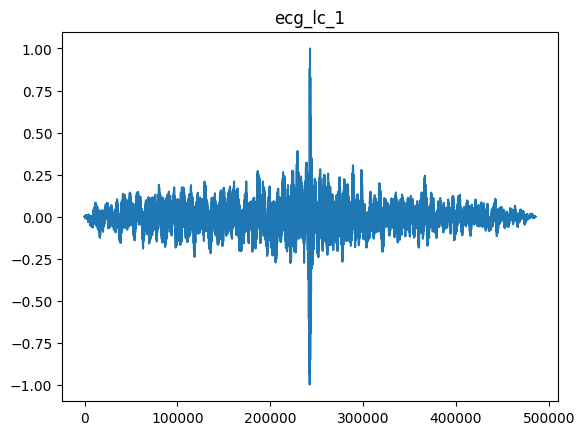

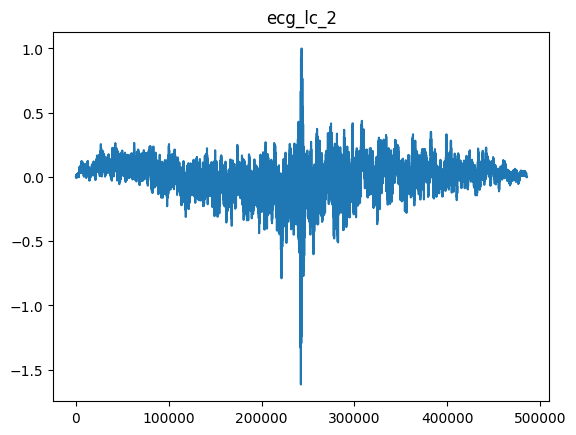

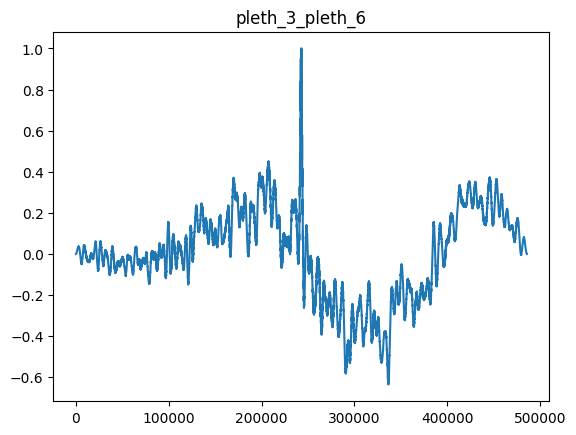

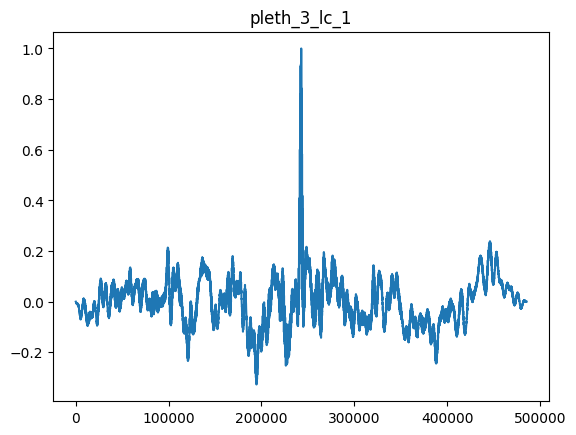

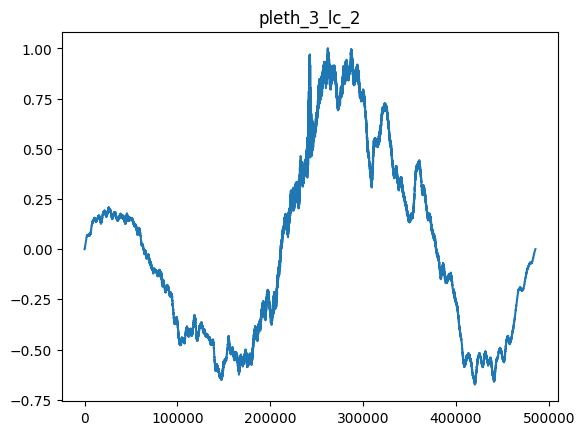

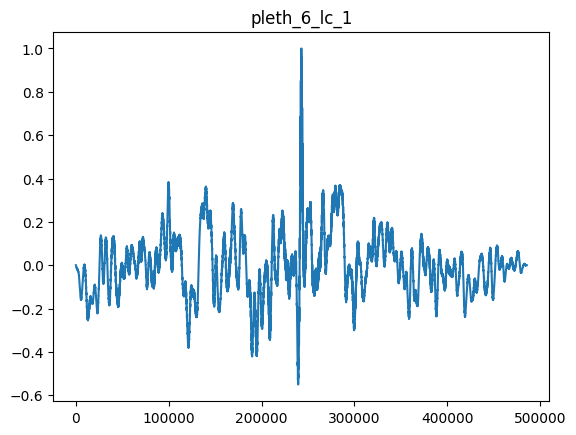

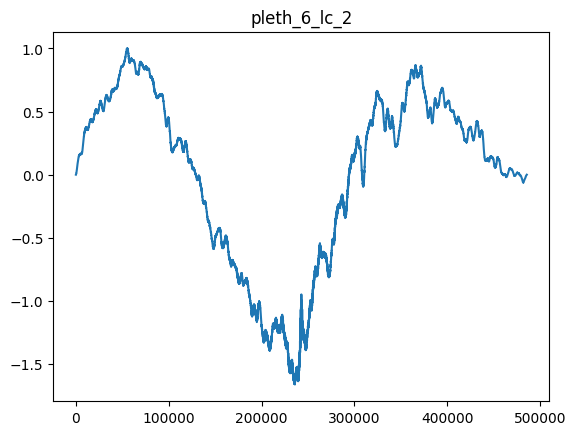

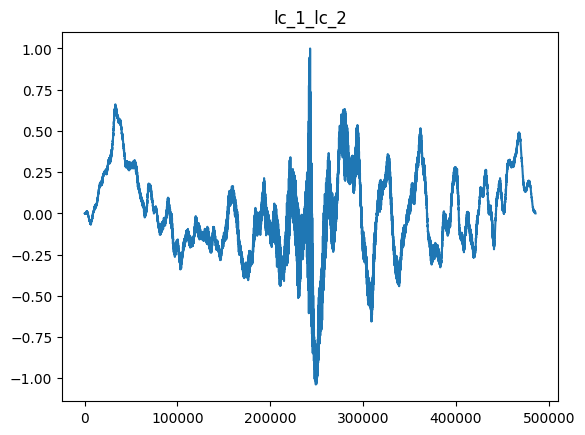

In [95]:
for key, value in cross_correlations.items():
    plt.figure()
    plt.plot(value, label=key)
    plt.title(key)
    plt.show()

In [2]:
files = glob.glob("data/s*.csv")
data = []
for file in files:

    activity = file.split("/")[-1].split("_")[1].split(".")[0]
    data_file: pd.DataFrame = pd.read_csv(file)
    data.append(
        {
            "activity": activity,
            "ecg_mean": data_file["ecg"].mean(),
            "temp_1_mean": data_file["temp_1"].mean(),
            "temp_2_mean": data_file["temp_2"].mean(),
            "pleth_3_mean": data_file["pleth_3"].mean(),
            "pleth_6_mean": data_file["pleth_6"].mean(),
            "lc_1_mean": data_file["lc_1"].mean(),
            "lc_2_mean": data_file["lc_2"].mean(),
        }
    )


data = pd.DataFrame(data)

/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/andres/digital_signal_processing/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

         run       0.60      0.50      0.55         6
         sit       0.00      0.00      0.00         4
        walk       0.44      1.00      0.62         4

    accuracy                           0.50        14
   macro avg       0.35      0.50      0.39        14
weighted avg       0.38      0.50      0.41        14



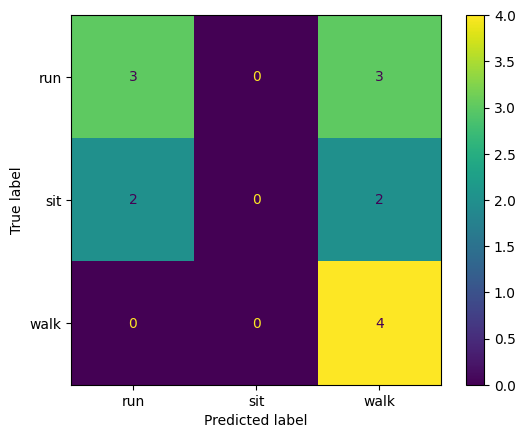

In [3]:
y = data["activity"]
X = data.drop(columns=["activity"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()